In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Set up loaders 
import sys; sys.path.append("..")
import proj_dataset
proj_dataset.FOLDERSPATH = r'..\\datasets'

# Set up cudas
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available(): torch.cuda.empty_cache()
print(f"using {device}")

using cuda


c:\Users\hanne\Desktop\d7047e\Project\BERT\..\proj_dataset.py:18: UserWarning: Disabling panda dataframe warnings, to enable comment out lines below
  warnings.warn("Disabling panda dataframe warnings, to enable comment out lines below")


In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [3]:
# OLID dataset
def get_loader(dataset, train_ds=False):
    texts = dataset["sentence"]
    labels = dataset["label1"]
    encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=128)

    # Convert to torch tensors
    seq = torch.tensor(encodings['input_ids'])
    mask = torch.tensor(encodings['attention_mask'])
    y = torch.Tensor(labels.astype(int).to_numpy())

    batch_size = 32

    if train_ds:
        data = TensorDataset(seq, mask, y)
        sampler = RandomSampler(data)
        dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)

    else:    
        data = TensorDataset(seq, mask, y)
        sampler = SequentialSampler(data)
        dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)

    return dataloader


In [4]:
tr_set, vl_set = proj_dataset._load_solid_set(size=40_000, tr_split_perc=0.8)
te1_set = proj_dataset._load_olid_test_set()
te2_set = proj_dataset._load_hasoc_test_set()

Loaded 100000 lines from file_off.xlsx to ensure sufficient randomness, cap: 20000
Loaded 100000 lines from file_not.xlsx to ensure sufficient randomness, cap: 20000
Loaded 13240 lines from ..\\datasets\\OLID\\OLID_Tain.txt
Loaded 5852 lines from english_dataset.tsv
Loaded 1153 lines from hasoc2019_en_test-2919.tsv


In [5]:
train_dataloader = get_loader(tr_set, train_ds=True)
val_dataloader = get_loader(vl_set)
test_loader_1 = get_loader(te1_set)
test_loader_2 = get_loader(te2_set)

In [6]:
# Model configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

# Optimizer and learning rate scheduler setup
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_dataloader) * 3  # Assuming 3 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\hanne\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [7]:
# Updated evaluate function
def evaluate(dataloader, in_loop=False):
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    y_true = []
    y_pred = []

    for batch in dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        b_labels = b_labels.to(int)
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        logits = outputs[1]
        loss = outputs[0]
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += np.sum(np.argmax(logits, axis=1) == label_ids)
        y_true.extend(label_ids)
        y_pred.extend(np.argmax(logits, axis=1))

    f1 = f1_score(y_true, y_pred)
    avg_loss = total_eval_loss / len(dataloader)
    return total_eval_accuracy / len(dataloader.dataset), avg_loss, f1


def test_model(model, test_loader):
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    y_true = []
    y_pred = []

    for batch in test_loader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        b_labels = b_labels.to(int)
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        logits = outputs[1]
        loss = outputs[0]
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += np.sum(np.argmax(logits, axis=1) == label_ids)
        y_true.extend(label_ids)
        y_pred.extend(np.argmax(logits, axis=1))

    f1 = f1_score(y_true, y_pred)

    # Calculate metrics
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix")
    print(confusion_matrix(y_true, y_pred))

In [8]:
# Validation function
train_losses = []
val_losses = []

# Training loop with loss tracking
for epoch in range(3):
    model.train()
    total_train_loss = 0
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        b_labels = b_labels.to(int)
        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    val_accuracy, avg_val_loss, val_f1 = evaluate(val_dataloader, in_loop=True)
    val_losses.append(avg_val_loss)
    print(
        f"Epoch {epoch + 1} | Train Loss: {avg_train_loss:.3f} | Validation Loss: {avg_val_loss:.3f} | Validation F1: {val_f1:.3f}")

Epoch 1 | Train Loss: 0.030 | Validation Loss: 0.006 | Validation F1: 0.998
Epoch 2 | Train Loss: 0.002 | Validation Loss: 0.002 | Validation F1: 0.999
Epoch 3 | Train Loss: 0.000 | Validation Loss: 0.002 | Validation F1: 0.999


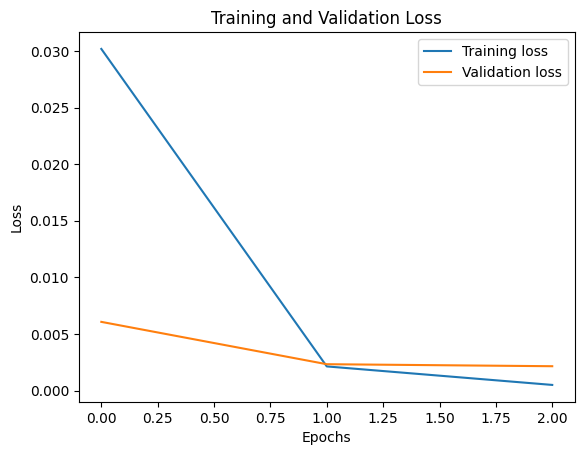

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.76      0.71      4400
           1       0.87      0.81      0.84      8840

    accuracy                           0.79     13240
   macro avg       0.77      0.78      0.77     13240
weighted avg       0.80      0.79      0.80     13240

Confusion Matrix
[[3323 1077]
 [1671 7169]]
Test OLID Accuracy: None
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.70      0.58      2549
           1       0.78      0.59      0.67      4456

    accuracy                           0.63      7005
   macro avg       0.64      0.65      0.63      7005
weighted avg       0.67      0.63      0.64      7005

Confusion Matrix
[[1784  765]
 [1811 2645]]
Test HASOC Accuracy: None


In [10]:
# Plot training and validation losses
plt.figure()
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on test set
test_accuracy = test_model(model, test_loader_1)
print(f"Test OLID Accuracy: {test_accuracy}")
test_accuracy = test_model(model, test_loader_2)
print(f"Test HASOC Accuracy: {test_accuracy}")